# 1. Data Analysis

## Data upload

In [171]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Preprocessing
from sklearn.cluster import KMeans
import tensorflow as tf   # Stratified Sampling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation
from sklearn.metrics import r2_score, mean_squared_error

# Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/MSML/Concrete/DATASET/domestic.csv",encoding='cp949')
df = df.drop(columns=['slag','ash', 'age'])   # Neither slag nor ash was used, and age feature is the same as the 28 days.

In [5]:
df.isnull().sum()

cement          0
water           0
superplastic    0
coarseagg       0
fineagg         0
strength        0
dtype: int64

## Check distribution of input features

In [6]:
len(df)

72

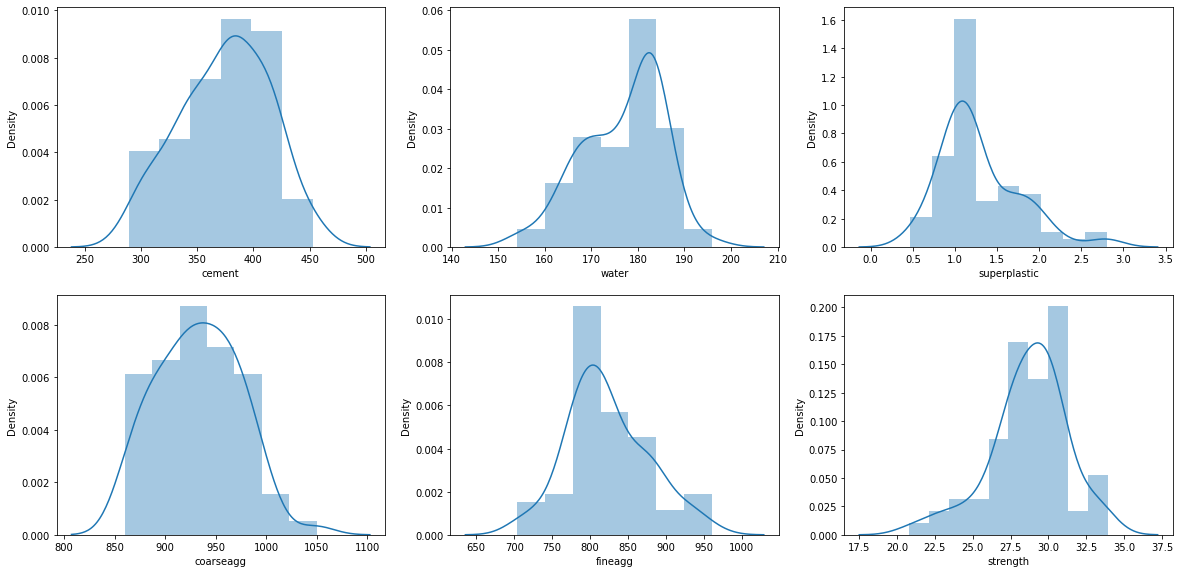

In [7]:
var=np.arange(1,len(df.columns)+1)
var
from IPython.core.pylabtools import figsize
figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    sns.distplot(df.iloc[:,(i-1)])

## Outliers

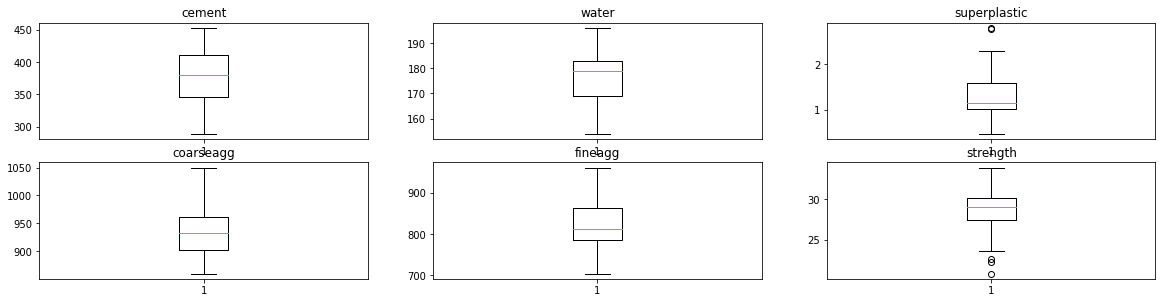

In [8]:
figsize(20, 15)
for i in var:
    plt.subplot(6,3,i)
    plt.boxplot(df.iloc[:,(i-1)])
    plt.title(df.columns[i-1])

A few variables a have some outliers. There are various methods of treating outliers. In this case, I am capping the outliers to the maximum possible value that is not an outlier.

In [9]:
Q1=np.percentile(df['superplastic'],25)
Q3=np.percentile(df['superplastic'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.superplastic=np.where(df.superplastic>UL, UL, df.superplastic)

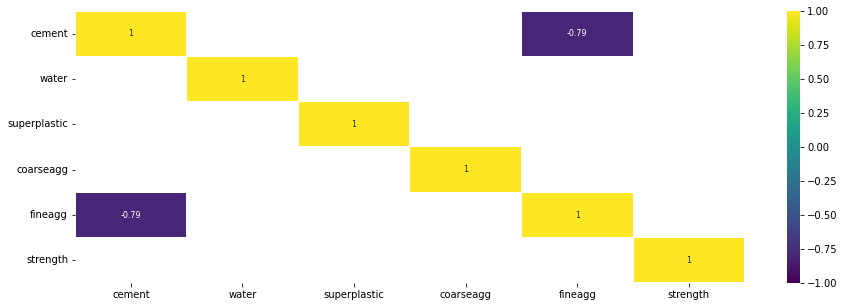

In [10]:
corr=df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(corr[(corr >= 0.70) | (corr <= -0.70)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8})

This corrrealtion is theoretically meaningless, so I will ignore it for now.

## Clustering Analysis

#### Elbow Method

Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 지점의 K 값을 군집의 개수로 사용. inertia_속성으로 확인 할 수 있다.

In [11]:
cl=np.arange(1,9)  # k_range
ess=[]   # ineretia_
for i in cl:
    clust=KMeans(n_init=15,n_clusters=i)
    clust.fit(df.iloc[:,0:5])
    error=clust.inertia_
    ess.append(error)

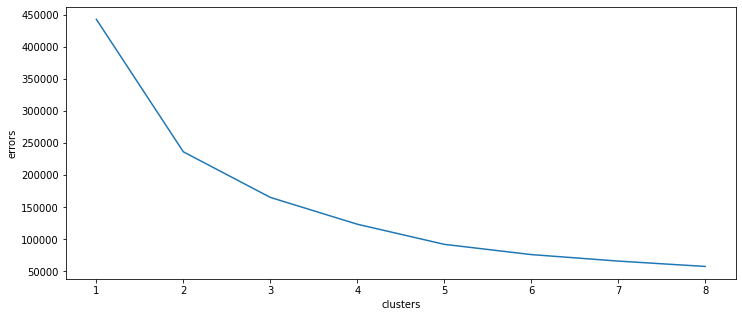

In [12]:
a=pd.DataFrame({'clusters':cl, 'errors':ess})
plt.figure(figsize=(12,5))
sns.lineplot(a.clusters, a.errors)

(1) At 2 clusters, elbow is seen.

In [48]:
clust=KMeans(n_init=15, n_clusters=2)
clust.fit(df.iloc[:,0:5])
df['cluster']=clust.predict(df.iloc[:,0:5])
df.cluster=pd.Categorical(df.cluster)

In [49]:
df.cluster.value_counts() , df.columns

(0    50
 1    22
 Name: cluster, dtype: int64,
 Index(['cement', 'water', 'superplastic', 'coarseagg', 'fineagg', 'strength',
        'strengthCat', 'cluster'],
       dtype='object'))

In [50]:
X=df.iloc[:,[0,1,2,3,4,6]].values
y=df.strength.values

**There seems to be three distinct clusters, especially when we see the distribution for strength of cement.**

---




There are a few more outliers when the distribution seen for each cluster which we may or may not want to treat depending on our model performances.

#### We check below the performance of models with addition of the new variable i.e. cluster

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
def test(models, X,y, iterations = 100):  # train/test set으로 나누고, model로 훈련시킨 후, 예측, 점수 계산하는 메소드
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=1)
            r2_test.append(r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [18]:
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.535191,0.422923,0.531407
1,0.191869,0.446457,0.279251


Hyperparameter Tuning / Regularization introduced

In [19]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS':LinearRegression(),
           'Lasso': GridSearchCV(Lasso(),param_grid=lasso_params, cv=10).fit(X,y).best_estimator_,
           'Ridge': GridSearchCV(Ridge(), 
                               param_grid=ridge_params, cv=10).fit(X, y).best_estimator_,}

test(models2, X,y)

,OLS,Lasso,Ridge
0,0.535191,0.533951,0.435113
1,0.191869,0.242343,0.456538


### Try the models without the new variable

In [20]:
X=df.iloc[:,0:5].values
y=df.strength.values

models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.451703,0.422923,0.451523
1,0.430672,0.446457,0.437480


No major difference observed with regularization. Also the addition of cluster did not improve the results.

In [51]:
df.drop('cluster', axis=1, inplace=True)

### So proceeding without the new column

In [21]:
X=df.iloc[:,0:5].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)

### Ridge

In [22]:
param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train,y_train)
Rid_gs.best_estimator_

Ridge(alpha=5)

In [23]:
print(Rid_gs.best_score_)
print("Train Rsq:%.2f" %r2_score(y_train,Rid_gs.predict(X_train)))
print("Test Rsq:%.2f" %r2_score(y_test,Rid_gs.predict(X_test)))
print()
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test))[0,1])

-4.733556525056111
Train Rsq:0.45
Test Rsq:0.45

Correlation_Test: 0.7841362332891615


In [24]:
Rid_gs.best_estimator_.coef_

array([-0.00520054, -0.2791968 ,  0.52893996, -0.05868369, -0.05946614])

Text(0.5, 1.0, 'Actuals v Predicted')

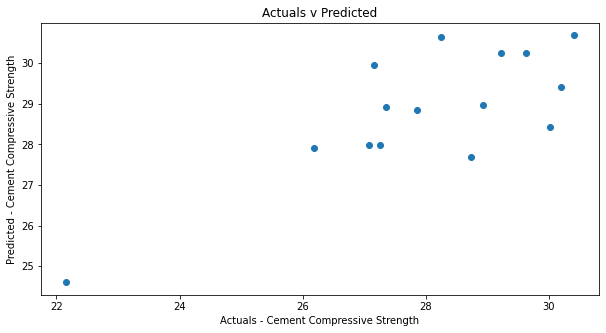

In [25]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, Rid_gs.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

### Lasso

In [26]:
param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Las=Lasso()
Las_gs=GridSearchCV(Las,param_grid, cv=10, scoring='neg_mean_squared_error')
Las_gs.fit(X_train,y_train)
Las_gs.best_estimator_

Lasso(alpha=0.001)

In [27]:
print(Las_gs.best_score_)
print("Train Rsq:%.2f" %r2_score(y_train,Las_gs.predict(X_train)))
print("Test Rsq:%.2f" %r2_score(y_test,Las_gs.predict(X_test)))
print()
print("Correlation_Test:", np.corrcoef(y_test,Las_gs.predict(X_test))[0,1])

-4.751981866858243
Train Rsq:0.45
Test Rsq:0.43

Correlation_Test: 0.7743709408369672


In [28]:
Las_gs.best_estimator_.coef_

array([-0.00764451, -0.27504659,  0.8517898 , -0.05998394, -0.06054563])

### Attempt to fit models by transforming the input variables to higher dimension

Try with polynomial

In [29]:
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=2)

X_train_tr=poly.fit_transform(X_train)
X_test_tr=poly.fit_transform(X_test)

#### Ridge

In [30]:
param_grid={'alpha':[0.1,0.5,1,2.5,5,10,20,30,35,36,37,38,39,40,41,42,43,45]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train_tr,y_train)
Rid_gs.best_estimator_

print(Rid_gs.best_score_)
print("Train Rsq:%.2f" %r2_score(y_train,Rid_gs.predict(X_train_tr)))
print("Test Rsq:%.2f" %r2_score(y_test,Rid_gs.predict(X_test_tr)))
print()
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test_tr))[0,1])

-6.657474813871078
Train Rsq:0.61
Test Rsq:-0.26

Correlation_Test: 0.4808094630206414


Result is worse than original dimension.

# 2. Data Preprocessing

## Stratified Sampling

**The feature scale needs to be fitted to the train data, so samplint before that.**

In [52]:
tf.random.set_seed(21) 
np.random.seed(21)

In [109]:
dist = [0.,
        df['strength'].quantile(q=0.2,interpolation='nearest'),
        df['strength'].quantile(q=0.4,interpolation='nearest'),
        df['strength'].quantile(q=0.6,interpolation='nearest'),
        df['strength'].quantile(q=0.8,interpolation='nearest'),
        np.inf]


df['strengthCat'] = pd.cut(df['strength'],    # Categorize by target feature(strength)
                                     bins=dist, 
                                     labels=[1,2,3,4,5])

In [110]:
df

,cement,water,superplastic,coarseagg,fineagg,strength,strengthCat
0,299,179,0.900,879,937,24.71,1
1,301,173,0.903,863,961,25.69,1
2,309,184,0.920,975,821,22.16,1
3,308,184,0.620,860,927,23.73,1
4,289,174,0.860,900,933,20.79,1
...,...,...,...,...,...,...,...
67,405,196,0.610,879,786,30.11,4
68,416,182,2.080,954,771,30.20,4
69,424,187,1.270,882,812,29.62,3
70,412,189,1.650,947,730,30.30,4


1    16
3    16
2    14
4    14
5    12
Name: strengthCat, dtype: int64


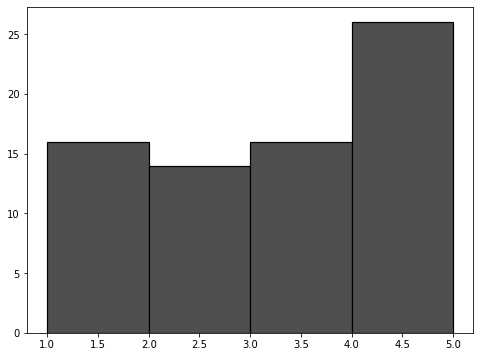

In [111]:
# check 
print(df['strengthCat'].value_counts())
figsize(8,6)
df['strengthCat'].hist(color='#4F4F4F', grid=False, bins=4, edgecolor='black', linewidth=1.2)

In [127]:
# Sampling based on caterogries
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df['strengthCat']):
    strat_train_valid = df.loc[train_idx]
    strat_test = df.loc[test_idx]

In [128]:
print(strat_train_valid.shape, strat_test.shape)

(57, 7) (15, 7)


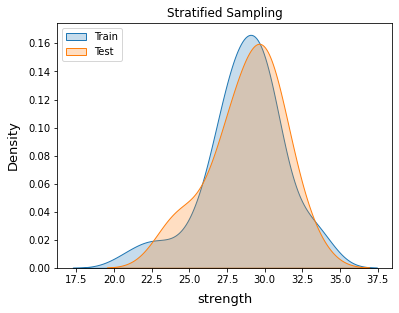

In [129]:
plt.figure(figsize=(6, 4.5))
sns.kdeplot(strat_train_valid['strength'], fill=True, label="Train")
sns.kdeplot(strat_test['strength'], fill=True,  label="Test")

plt.legend(loc='upper left')
plt.title("Stratified Sampling")
plt.xlabel('strength', fontsize=13, labelpad=8)
plt.ylabel('Density', fontsize=13, labelpad=8)

plt.savefig('/content/drive/MyDrive/MSML/Concrete/Fig/Korean/stratified_sampling.png')

Split valid

In [130]:
strat_train_valid.reset_index(drop=True, inplace=True)

In [133]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)

for train_idx, valid_idx in split.split(strat_train_valid, strat_train_valid['strengthCat']):
    strat_train = strat_train_valid.loc[train_idx]
    strat_valid = strat_train_valid.loc[valid_idx]

In [134]:
print(strat_train.shape, strat_valid.shape)

(48, 7) (9, 7)


In [135]:
# remove the 'strengthCat' column
for df_ in (strat_train, strat_test):
    # set_.drop('Sum of amorphous aluminosilicates Cat', axis=1, inplace=True)
    df_.reset_index(drop=True, inplace=True)


Compare Ordinary Sampling

In [56]:
X = df.drop('strength', axis=1)
y = df['strength']

sampling_X_train, sampling_X_test, sampling_y_train, sampling_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

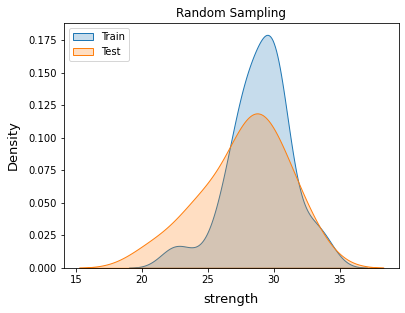

In [57]:
plt.figure(figsize=(6, 4.5))
sns.kdeplot(sampling_y_train, fill=True, label="Train")
sns.kdeplot(sampling_y_test, fill=True,  label="Test")

plt.legend(loc='upper left')
plt.title("Random Sampling")
plt.xlabel('strength', fontsize=13, labelpad=8)
plt.ylabel('Density', fontsize=13, labelpad=8)
# plt.show()

plt.savefig('/content/drive/MyDrive/MSML/Concrete/Fig/Korean/nomal_sampling.png')

## Feature Scale

In [62]:
strat_train.columns

Index(['cement', 'water', 'superplastic', 'coarseagg', 'fineagg', 'strength',
       'cluster', 'strengthCat'],
      dtype='object')

In [137]:
X_train = strat_train.iloc[:,:5]
y_train = pd.DataFrame(strat_train.iloc[:,5])

X_valid = strat_valid.iloc[:,:5]
y_valid = pd.DataFrame(strat_valid.iloc[:,5])

X_test = strat_test.iloc[:,:5]
y_test = pd.DataFrame(strat_test.iloc[:,5])

In [138]:
scalerX = StandardScaler().fit(X_train)  
scalery = StandardScaler().fit(y_train)

X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)

X_valid = scalerX.transform(X_valid)
y_valid = scalery.transform(y_valid)

X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

# 3. Model Selection

(1) SVM    
(2) XGBoost    
(3) GBM   
(4) RF   
(5) Stacking   

## SVM

In [142]:
# for calculate Adjusted-R2
input_features = ['cement', 'water', 'superplastic', 'coarseagg', 'fineagg']
n_train, n_valid, n_test = len(X_train), len(X_valid), len(X_test) 
p_train, p_valid, p_test = len(input_features), len(input_features), len(input_features) 

In [147]:
def MAPE(true, pred): 
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

In [158]:
model = SVR()
model.fit(X_train, y_train)
print("Rsq (Train): %.2g" % r2_score(y_train, model.predict(X_train)))

Rsq (Train): 0.7


### Tune Haperparameter

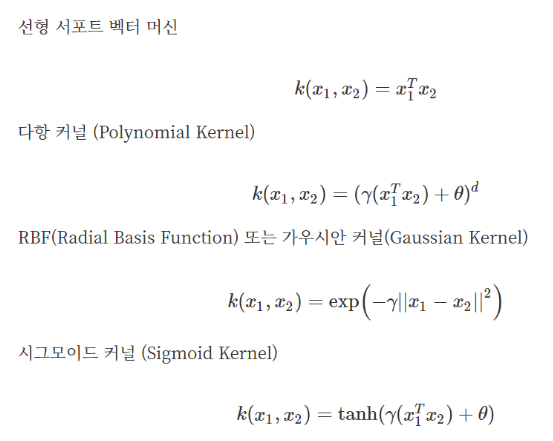

- C	(1.0) : How many errors are allowed (Regulation term).   Overfitting if C value is too large.
- kernel (rbf) : [unlinear dataset] 'rbf(gaussian)', 'poly', 'sigmoid'    [linear dataset] 'linear' 
- degree (3) :	Order d of 'poly' kernel expressions
- gamma	(scale) : Determine how flexible (curving) the decision boundaries are to be drawn. Larger the likelihood of overfitting
-coef0 (0.0) : Constant term r in the 'poly' kernel


https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-2%EC%84%9C%ED%8F%AC%ED%8A%B8-%EB%B2%A1%ED%84%B0-%EB%A8%B8%EC%8B%A0-SVM

In [161]:
param_grid = {'kernel': ['rbf','sigmoid', 'poly'], 
              # 'gamma': [1e-2, 1e-3, 1e-4],
              'C': [0.1, 1, 5, 10, 25, 50]}

gsearch1 = GridSearchCV(estimator = SVR(),param_grid = param_grid, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
gs1=gsearch1.fit(X_train,y_train)

In [162]:
print(gs1.best_params_, gs1.best_score_)
print("=====Model Report====")
Rsq_train=r2_score(y_train,gs1.predict(X_train))
Rsq_valid=r2_score(y_valid,gs1.predict(X_valid))
print("Rsq (train):%.2f"%Rsq_train)
print("Rsq (valid):%.2f"%Rsq_valid)
print("---------------------")
Rsq_Adj_train= 1- (((1-Rsq_train)*(n_train-1))/(n_train-p_train-1))
Rsq_Adj_valid= 1- (((1-Rsq_valid)*(n_valid-1))/(n_valid-p_valid-1))
print('Rsq_Adj (train):%.2f'%Rsq_Adj_train)
print('Rsq_Adj (valid):%.2f'%Rsq_Adj_valid)
print("---------------------")
MAPE_train=MAPE(y_train,gs1.predict(X_train))
MAPE_valid=MAPE(y_valid,gs1.predict(X_valid))
print('MAPE (train):%.2f'%MAPE_train)
print('MAPE (valid):%.2f'%MAPE_valid)

{'C': 5, 'kernel': 'poly'} -0.551017669097142
=====Model Report====
Rsq (train):0.77
Rsq (valid):0.34
---------------------
Rsq_Adj (train):0.74
Rsq_Adj (valid):-0.77
---------------------
MAPE (train):361.18
MAPE (valid):310.22


MAPE >100% means that the errors are "much greater" then the actual values (e.g. actual is 1, you predict 3, so MAPE is 200%). 

In [169]:
param_grid = {'C': [1,3,5,10,20], 
              'degree':np.arange( 0, 10, 2 ).tolist(), 
              'coef0':np.arange( 0, 10, 2 ).tolist(),
              'gamma':['scale', 'auto', 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]}

gsearch2 = GridSearchCV(estimator = SVR(kernel='poly'),param_grid = param_grid, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
gs2=gsearch2.fit(X_train,y_train)

In [170]:
print(gs2.best_params_, gs2.best_score_)
print("=====Model Report====")
Rsq_train=r2_score(y_train,gs2.predict(X_train))
Rsq_valid=r2_score(y_valid,gs2.predict(X_valid))
print("Rsq (train):%.2f"%Rsq_train)
print("Rsq (valid):%.2f"%Rsq_valid)
print("---------------------")
Rsq_Adj_train= 1- (((1-Rsq_train)*(n_train-1))/(n_train-p_train-1))
Rsq_Adj_valid= 1- (((1-Rsq_valid)*(n_valid-1))/(n_valid-p_valid-1))
print('Rsq_Adj (train):%.2f'%Rsq_Adj_train)
print('Rsq_Adj (valid):%.2f'%Rsq_Adj_valid)
print("---------------------")
MAPE_train=MAPE(y_train,gs2.predict(X_train))
MAPE_valid=MAPE(y_valid,gs2.predict(X_valid))
print('MAPE (train):%.2f'%MAPE_train)
print('MAPE (valid):%.2f'%MAPE_valid)

{'C': 20, 'coef0': 4, 'degree': 8, 'gamma': 0.0001} -0.5178513812363064
=====Model Report====
Rsq (train):0.70
Rsq (valid):-0.11
---------------------
Rsq_Adj (train):0.66
Rsq_Adj (valid):-1.95
---------------------
MAPE (train):356.85
MAPE (valid):398.99


SVM prediction is not accurate

## GBM

In [172]:
model=GradientBoostingRegressor()
model.fit(X_train,y_train)

GradientBoostingRegressor()

#### Parameter Tuning.

Boosting 파라미터
*   n_estimators(트리 수), 훈련을 제어하는 변수 : {'n_estimators':range(20,150,10)}
*   max_depth, 성장을 제어하는 변수 : {'max_depth':range(5,16,2)}
*   min_samples_split : {'min_samples_split':range(10,100,10)}
*   max_features : {'max_features':range(2,5,1)}


## Random Forest

In [181]:
rf= RandomForestRegressor(random_state=False, n_estimators = 100)

rf.fit(X_train, y_train)

RandomForestRegressor(random_state=False)

In [183]:
print("=====Model Report====")
Rsq_train=r2_score(y_train,rf.predict(X_train))
Rsq_valid=r2_score(y_valid,rf.predict(X_valid))
print("Rsq (train):%.2f"%Rsq_train)
print("Rsq (valid):%.2f"%Rsq_valid)
print("---------------------")
Rsq_Adj_train= 1- (((1-Rsq_train)*(n_train-1))/(n_train-p_train-1))
Rsq_Adj_valid= 1- (((1-Rsq_valid)*(n_valid-1))/(n_valid-p_valid-1))
print('Rsq_Adj (train):%.2f'%Rsq_Adj_train)
print('Rsq_Adj (valid):%.2f'%Rsq_Adj_valid)
print("---------------------")
MAPE_train=MAPE(y_train,rf.predict(X_train))
MAPE_valid=MAPE(y_valid,rf.predict(X_valid))
print('MAPE (train):%.2f'%MAPE_train)
print('MAPE (valid):%.2f'%MAPE_valid)

=====Model Report====
Rsq (train):0.94
Rsq (valid):0.75
---------------------
Rsq_Adj (train):0.93
Rsq_Adj (valid):0.33
---------------------
MAPE (train):397.52
MAPE (valid):207.44


### Tune Hyperparameter

- n_estimators(10): range(20,150,10)
- max_depth(None): range(4,16,2)
- min_samples_split(2): range(10,100,10)
- max_features(auto): range(3,7,1)

In [207]:
param_test1 = {'n_estimators':range(5, 25, 5)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(random_state=False),
                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1, cv=10)
gs1=gsearch1.fit(X_train,y_train)
gs1.best_params_, gs1.best_score_

({'n_estimators': 20}, -0.5386063110058156)

In [208]:
print("=====Model Report====")
Rsq_train=r2_score(y_train,gs1.predict(X_train))
Rsq_valid=r2_score(y_valid,gs1.predict(X_valid))
print("Rsq (train):%.2f"%Rsq_train)
print("Rsq (valid):%.2f"%Rsq_valid)
print("---------------------")
Rsq_Adj_train= 1- (((1-Rsq_train)*(n_train-1))/(n_train-p_train-1))
Rsq_Adj_valid= 1- (((1-Rsq_valid)*(n_valid-1))/(n_valid-p_valid-1))
print('Rsq_Adj (train):%.2f'%Rsq_Adj_train)
print('Rsq_Adj (valid):%.2f'%Rsq_Adj_valid)
print("---------------------")
MAPE_train=MAPE(y_train,gs1.predict(X_train))
MAPE_valid=MAPE(y_valid,gs1.predict(X_valid))
print('MAPE (train):%.2f'%MAPE_train)
print('MAPE (valid):%.2f'%MAPE_valid)

=====Model Report====
Rsq (train):0.92
Rsq (valid):0.68
---------------------
Rsq_Adj (train):0.91
Rsq_Adj (valid):0.15
---------------------
MAPE (train):390.12
MAPE (valid):194.96


In [216]:
param_test2 = {'max_depth':range(4,16,2), 'min_samples_split':range(10,100,10)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(random_state=False, n_estimators=10),
                                                          param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=-1, cv=10)
gs2=gsearch2.fit(X_train,y_train)
gs2.best_params_, gs2.best_score_

({'max_depth': 6, 'min_samples_split': 10}, -0.5640501727249927)

In [217]:
print("=====Model Report====")
Rsq_train=r2_score(y_train,gs2.predict(X_train))
Rsq_valid=r2_score(y_valid,gs2.predict(X_valid))
print("Rsq (train):%.2f"%Rsq_train)
print("Rsq (valid):%.2f"%Rsq_valid)
print("---------------------")
Rsq_Adj_train= 1- (((1-Rsq_train)*(n_train-1))/(n_train-p_train-1))
Rsq_Adj_valid= 1- (((1-Rsq_valid)*(n_valid-1))/(n_valid-p_valid-1))
print('Rsq_Adj (train):%.2f'%Rsq_Adj_train)
print('Rsq_Adj (valid):%.2f'%Rsq_Adj_valid)
print("---------------------")
MAPE_train=MAPE(y_train,gs2.predict(X_train))
MAPE_valid=MAPE(y_valid,gs2.predict(X_valid))
print('MAPE (train):%.2f'%MAPE_train)
print('MAPE (valid):%.2f'%MAPE_valid)

=====Model Report====
Rsq (train):0.79
Rsq (valid):0.71
---------------------
Rsq_Adj (train):0.76
Rsq_Adj (valid):0.22
---------------------
MAPE (train):354.08
MAPE (valid):200.37


In [221]:
param_test3 = {'max_features':range(3,7,1), 'min_samples_leaf':range(10,100,10)}

gsearch3 = GridSearchCV(estimator = RandomForestRegressor(random_state=False, max_depth= 6, min_samples_split=10),
                        param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1, cv=10)
gs3=gsearch3.fit(X_train,y_train)
gs3.best_params_, gs3.best_score_

({'max_features': 4, 'min_samples_leaf': 10}, -0.808523613262393)

In [222]:
print("=====Model Report====")
Rsq_train=r2_score(y_train,gs3.predict(X_train))
Rsq_valid=r2_score(y_valid,gs3.predict(X_valid))
print("Rsq (train):%.2f"%Rsq_train)
print("Rsq (valid):%.2f"%Rsq_valid)
print("---------------------")
Rsq_Adj_train= 1- (((1-Rsq_train)*(n_train-1))/(n_train-p_train-1))
Rsq_Adj_valid= 1- (((1-Rsq_valid)*(n_valid-1))/(n_valid-p_valid-1))
print('Rsq_Adj (train):%.2f'%Rsq_Adj_train)
print('Rsq_Adj (valid):%.2f'%Rsq_Adj_valid)
print("---------------------")
MAPE_train=MAPE(y_train,gs3.predict(X_train))
MAPE_valid=MAPE(y_valid,gs3.predict(X_valid))
print('MAPE (train):%.2f'%MAPE_train)
print('MAPE (valid):%.2f'%MAPE_valid)

=====Model Report====
Rsq (train):0.34
Rsq (valid):0.25
---------------------
Rsq_Adj (train):0.27
Rsq_Adj (valid):-1.01
---------------------
MAPE (train):272.10
MAPE (valid):201.66


The optimal value resulting from gridsearch is not the actual optimal value. This seems to be because the number of data is too small to gridsearch.

## XGBoost

In order to decide on boosting parameters, we need to set some initial values of other parameters.

In [174]:
xgb = XGBRegressor(booster='gbtree',
                    learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

xgb.fit(X_train,y_train)

[11:53:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=1000, nthread=4,
             seed=27, subsample=0.8)

In [175]:
print("=====Model Report====")
Rsq_train=r2_score(y_train,xgb.predict(X_train))
Rsq_valid=r2_score(y_valid,xgb.predict(X_valid))
print("Rsq (train):%.2f"%Rsq_train)
print("Rsq (valid):%.2f"%Rsq_valid)
print("---------------------")
Rsq_Adj_train= 1- (((1-Rsq_train)*(n_train-1))/(n_train-p_train-1))
Rsq_Adj_valid= 1- (((1-Rsq_valid)*(n_valid-1))/(n_valid-p_valid-1))
print('Rsq_Adj (train):%.2f'%Rsq_Adj_train)
print('Rsq_Adj (valid):%.2f'%Rsq_Adj_valid)
print("---------------------")
MAPE_train=MAPE(y_train,xgb.predict(X_train))
MAPE_valid=MAPE(y_valid,xgb.predict(X_valid))
print('MAPE (train):%.2f'%MAPE_train)
print('MAPE (valid):%.2f'%MAPE_valid)

=====Model Report====
Rsq (train):1.00
Rsq (valid):0.31
---------------------
Rsq_Adj (train):1.00
Rsq_Adj (valid):-0.85
---------------------
MAPE (train):459.19
MAPE (valid):217.26


### Hyperparameter Tuning

#### Tune max_depth and min_child_weight

In [179]:
param_test1 = {
 'max_depth':range(3,8,1),
 'min_child_weight':range(1,6,1)
}

gsearch1 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=5)

gs1=gsearch1.fit(X_train,y_train)
gs1.best_params_, gs1.best_score_

[11:56:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 6, 'min_child_weight': 1}, -0.5101065622981333)

In [180]:
print("=====Model Report====")
Rsq_train=r2_score(y_train,gs1.predict(X_train))
Rsq_valid=r2_score(y_valid,gs1.predict(X_valid))
print("Rsq (train):%.2f"%Rsq_train)
print("Rsq (valid):%.2f"%Rsq_valid)
print("---------------------")
Rsq_Adj_train= 1- (((1-Rsq_train)*(n_train-1))/(n_train-p_train-1))
Rsq_Adj_valid= 1- (((1-Rsq_valid)*(n_valid-1))/(n_valid-p_valid-1))
print('Rsq_Adj (train):%.2f'%Rsq_Adj_train)
print('Rsq_Adj (valid):%.2f'%Rsq_Adj_valid)
print("---------------------")
MAPE_train=MAPE(y_train,gs1.predict(X_train))
MAPE_valid=MAPE(y_valid,gs1.predict(X_valid))
print('MAPE (train):%.2f'%MAPE_train)
print('MAPE (valid):%.2f'%MAPE_valid)

=====Model Report====
Rsq (train):1.00
Rsq (valid):0.24
---------------------
Rsq_Adj (train):1.00
Rsq_Adj (valid):-1.03
---------------------
MAPE (train):456.73
MAPE (valid):206.91


In [ ]:
param_test2 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor(booster='gbtree', learning_rate =0.1, n_estimators=100,
                                                 max_depth=3, min_child_weight=4,
                                                 nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch1.best_score_

[13:48:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 1}, -4.671299928283342)

[13:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.9396
Rsq (Test): 0.707




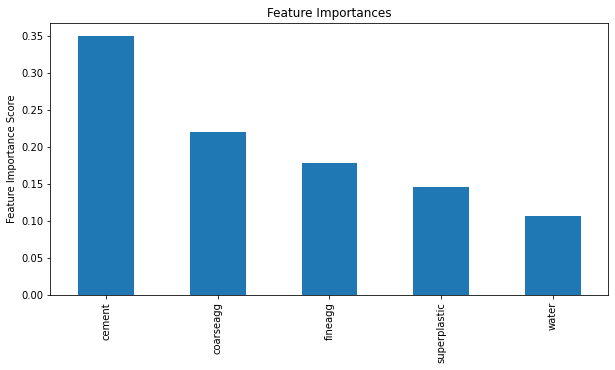

In [ ]:
plt.figure(figsize=(10,5))
modelfit(gsearch2.best_estimator_, X_train, X_test, predictors)

Fine Tuning

In [ ]:
param_test3 = {
 'reg_alpha':[0.8, 0.9, 1, 1.2, 1.3, 1.4, 1.5, 2]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
                                                  max_depth=3, min_child_weight=4,
                                                  nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch1.best_score_

[13:54:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 1.5}, -4.671299928283342)

[13:54:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.926
Rsq (Test): 0.7414




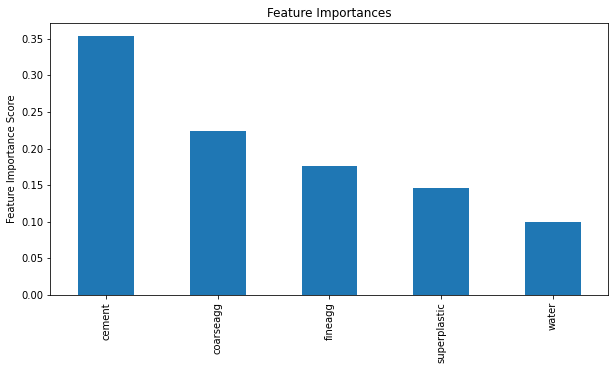

In [ ]:
plt.figure(figsize=(10,5))
modelfit(gsearch3.best_estimator_, X_train, X_test, predictors)

In [ ]:
XGB= XGBRegressor(booster='gbtree', learning_rate =0.1, n_estimators=100,
                  max_depth=3, min_child_weight=4,
                  reg_alpha=1.5, 
                  nthread=4, scale_pos_weight=1, seed=27)

[14:01:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.926
Rsq (Test): 0.7414




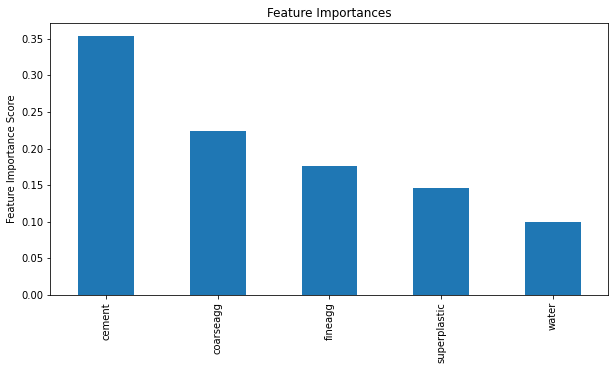

In [ ]:
plt.figure(figsize=(10,5))
modelfit(XGB, X_train, X_test, predictors)

XGB is the final model.

Text(0.95, 0.14, 'Train : $R^2$ =0.926\nTest: $R^2$ =0.741')

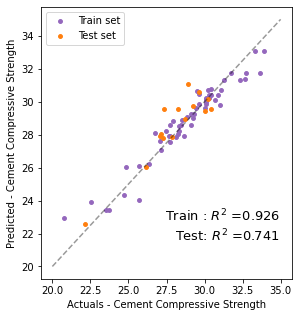

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,5))

ax.scatter(y_train, XGB.predict(X_train), color='C4', label='Train set', s=15)
ax.scatter(y_test, XGB.predict(X_test), color='C1', label='Test set', s=15)

ax.set_xlabel("Actuals - Cement Compressive Strength")
ax.set_ylabel("Predicted - Cement Compressive Strength")
ax.legend(loc='upper left')

# y=x dashed line
ax.plot([20,35], [20,35], c="k", linestyle='--',alpha=0.4)

ax.text(0.95, 0.14, f"Train : $R^2$ ={r2_score(y_train,XGB.predict(X_train)):0.3f}\nTest: $R^2$ ={r2_score(y_test, XGB.predict(X_test)):0.3f}",
        transform=ax.transAxes, fontsize=13, ha="right")

In [ ]:
df.strength.describe()

count    72.000000
mean     28.689583
std       2.578204
min      20.790000
25%      27.435000
50%      29.030000
75%      30.200000
max      33.930000
Name: strength, dtype: float64

In [ ]:
len(df)

72

# 4. Evaluation

In [ ]:
input = pd.DataFrame(columns=df.iloc[:,0:5].columns)
input.loc[0] = [550, 148, 12.1, 1056, 700]
input

,cement,water,superplastic,coarseagg,fineagg
0,550.0,148.0,12.1,1056.0,700.0


In [ ]:
XGB.predict(input)

array([29.536282], dtype=float32)